# Building User Interfaces For AI Applications with Gradio in Python

# Creating User Interfaces for AI Applications with Gradio

## Introduction


The usefulness of today's AI models are greatly diminished without accessible user interfaces. Using Gradio, an open-source Python web UI library, you can bridge that gap between LLMs and non-technical end users. It allows you to create rapid prototypes for your AI projects and simplify their deployment to a wider audience. 

This tutorial is aimed at machine learning engineers who typically don't have any web development experience. It covers:
 
- Gradio basics and core concepts
- Interface creation for various AI model types
- Advanced features for UX and interactivity
- Deployment and sharing best practices

Let's get started.

## Getting Started with Gradio

### Installation

We will get started by creating a virtual environment (preferably Conda):

```
$ conda create -n gradio_tutorial python=3.9 -y
$ conda activate gradio_tutorial
```

Then, you can use PIP to install Gradio and its dependencies:

```
$ pip install gradio ipykernel
```

We've also installed the `ipykernel` package so that we can display Gradio interfaces straight within Jupyter notebooks. This process requires you to add the virtual environment you created as a kernel to Jupyter Lab. Here is the command to do it:

```
$ ipython kernel install --user --name==gradio_tutorial
$ jupyter lab  # Start the lab
```

This should allow you to create a notebook with a kernel that has Gradio installed. To check, import it under its standard alias and print its version:

In [1]:
import gradio as gr

print(gr.__version__)

4.37.1


### Basic concepts and terminology

Let's learn core Gradio concepts and terminology through a simple "Hello World" example:

```python
def greet(name):
    return f"Hello, {name}!"


demo = gr.Interface(
    fn=greet,
    inputs=['text'],
    outputs="text",
)

demo.launch()
```

When you run the above code in a cell, the output will be a small interactive interface that greets the text input:

![](images/hello_world.gif)

Gradio revolves around a few key concepts:
1. Interface: the core class for creating UIs.
2. Components: Input and output elements like text boxes, images and audio. There are more than 30 built-in components as of now. 
3. Functions: Python functions that processes the information from the input components and returns them to display with output components.
4. Launch: The method to start your Gradio app. 

Above, we created a `greet` function that takes and returns a text input. For this reason, the input and output components are specified as `text` inside the `Interface` class. 

In the end, we are calling the `launch` method, which starts a local server. To make the UI available to anyone, you can set the `share` parameter to True. This will start an SSH tunnel and deploys the Gradio app to a publicly shareable link:

```python
demo.launch(share=True)
```

```
Running on public URL: https://d638ed5f2ce0044296.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
```

Be sure to read the [Quickstart](https://www.gradio.app/main/guides/quickstart) page of Gradio docs for more information.

## Gradio Components

### Input and output components

Gradio offers a wide array of components for building interactive interfaces. These components are generally divided into two categories: input and output. 

Input components allow users to provide data to the underlying processor (this can be a machine learning model wrapped into a function). Some common inputs are:
- Textbox
- Image
- Audio
- Slider
- Dropdown

Here is a dummy interface that uses some of the components above:

```python
def process_inputs(text, image, audio, number, option):
    # Process inputs and return results
    return f"Processed: {text}, {number}, {option}"


demo = gr.Interface(
    fn=process_inputs,
    inputs=[
        gr.Textbox(label="Enter text"),
        gr.Image(label="Upload image"),
        gr.Audio(label="Upload audio"),  # Uncomment this line to add audio input
        gr.Slider(0, 100, label="Choose a number"),
        gr.Dropdown(["Streamlit", "Taipy", "Gradio"], label="Select a UI library"),
    ],
    outputs="text",
)

demo.launch()
```

![](images/components.gif)

This time we are using a `Textbox` class to specify the input component instead of a plain string `text` like the first example. It is always recommended to use dedicated classes for specifying input and output components to make them customizable. For example, all component classes have a useful `label` attribute, while `Slider` and `Dropdown` have arguments to specify range and available options. 

Output components display the results of your work. Common output components include:
- Label: For displaying text or classification results
- Image: For showing processed or generated images
- Audio: For playing processed or generated audio
- Plot: For displaying graphs or charts

### Customizing component appearance

Gradio allows you to customize the appearance of your components to suit your aesthetic needs. Here is an example that uses customized text boxes:

```python
demo = gr.Interface(
    fn=lambda x: int(x) ** 7,
    inputs=gr.Textbox(
        lines=5,
        placeholder="Enter any number...",
        label="Custom textbox",
        info="This is a customized textbox component to raise any number to the power of 7.",
    ),
    outputs=gr.Textbox(label="And the number is...", show_copy_button=True),
)

demo.launch()
```

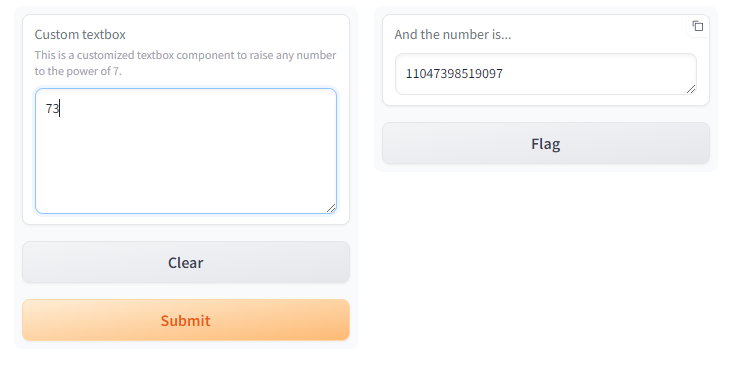

In this example, we've customized the Textbox components by specifying the number of lines, adding a placeholder and info text, and including a copy button for the output.

Experiment with different components and their properties to create interfaces that best suit your AI application's requirements. To find out what kind of properties you can change for your component, you can visit its docs or better yet, use the `?` operand in Jupyter Lab after a class or function name:

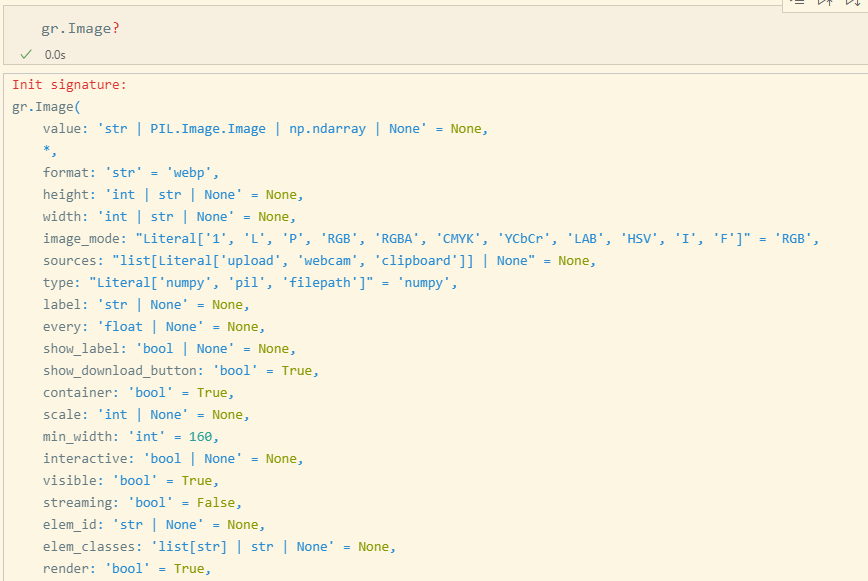

## Building Interfaces Using LLMs

Let's put everything we've learned together by creating two real-world text and image-based interfaces that are powered by LLMs. 

First, we will build a language translator from English to Turkish, Spanish or Chinese:

In [8]:
import openai  # pip install openai


def translate_text(api_key, text, target_language):
    openai.api_key = api_key
    language_map = {
        "Turkish": "Turkish",
        "Spanish": "Spanish",
        "Chinese": "Chinese (Simplified)",
    }
    prompt = f"Translate the following English text to {language_map[target_language]}:\n\nEnglish: {text}\n\n{target_language} translation:"

    try:
        response = openai.chat.completions.create(
            model="gpt-4",
            messages=[
                {"role": "system", "content": "You are a professional translator."},
                {"role": "user", "content": prompt},
            ],
        )
        translation = response.choices[0].message.content.strip()
        return translation
    except Exception as e:
        return f"Error: {str(e)}"

Initially, we define a `translate_text` function. In its body, we set the OpenAI API key and create a language map. Then, we construct the prompt for translation. Then, inside a `try-except` block, we send a request to the `ChatCompletion` endpoint with a system prompt. In the end, we return the first choice. 

Now, we can build the interface:

```python
iface = gr.Interface(
    fn=translate_text,
    inputs=[
        gr.Textbox(
            placeholder="Enter your OpenAI API key",
            type="password",
            label="OpenAI API Key",
        ),
        gr.Textbox(
            lines=4,
            placeholder="Enter English text to translate...",
            label="English Text",
        ),
        gr.Dropdown(choices=["Turkish", "Spanish", "Chinese"], label="Target Language"),
    ],
    outputs=gr.Textbox(label="Translation", show_copy_button=True),
    title="English to Turkish/Spanish/Chinese Translator",
    description="Translate English text to Turkish, Spanish, or Chinese using OpenAI's GPT-4 model. Enter your OpenAI API key, the text you want to translate, and select the target language.",
)

iface.launch(share=True)
```

The code is simple like those of earlier interfaces but we are introducing a couple of new properties:
- `type` argument of text boxes change the plain-text input field to password which hides the text
- `title` and `description` arguments of `Interface` class adds an H1 title and a subtitle to the top center of the page.

Here is the result:

![](images/translator.gif)

You might wonder why we are asking user's API key as part of the app rather than provide it ourselves. The reason has got to do with how Gradio deploys UIs.

If we provided our own API key as an environment variable (which is a standard practice), the publicly shareable app version wouldn't work as it wouldn't have access to our environment variables. In the deployment section, we will see how to fix this by deploying our apps to HuggingFace spaces.

Let's build another UI but for generating images this time:

In [29]:
def generate_surrealist_art(api_key, prompt):
    surrealist_prompt = f"Create a surrealist artwork based on the following concept: {prompt}. The artwork should be dreamlike, with unexpected juxtapositions and a sense of the uncanny."

    client = OpenAI(api_key=api_key)

    response = client.images.generate(
        model="dall-e-3",
        prompt=surrealist_prompt,
        size="1024x1024",
    )

    image_url = response.data[0].url

    return image_url

We create a function named `generate_surrealist_art` that sends a request to `dall-e-3` and returns the generated image URL. Then, we will feed this function into an `Interface` class again:

```python
iface = gr.Interface(
    fn=generate_surrealist_art,
    inputs=[
        gr.Textbox(
            placeholder="Enter your OpenAI API key",
            type="password",
            label="OpenAI API Key",
        ),
        gr.Textbox(
            lines=2,
            placeholder="Describe your surrealist concept...",
            label="Concept Description",
        ),
    ],
    outputs=gr.Image(value="str"),
    title="Surrealist Artwork Generator",
    description="Generate surrealist artwork based on your prompts using DALL-E. Enter your OpenAI API key and describe your concept.",
)

iface.launch(share=True)
```

For the `Image` component to accept URLs, we set its `value` parameter to `str`. Here is the result:

![](images/image_generator_2.gif)

## Building Interfaces Using Classic ML Models

## V. Advanced Gradio Features
- Multiple inputs and outputs
- State and memory
- Event listeners and interactivity
- Themes and styling



## VI. Integrating ML Models
- Loading pre-trained models
- Connecting model inputs and outputs to Gradio components
- Handling preprocessing and postprocessing



## VII. Deploying Gradio Apps
- Local deployment
- Sharing temporary links
- Hosting on Hugging Face Spaces



## VIII. Best Practices and Tips
- Performance optimization
- User experience considerations
- Error handling and feedback



## IX. Conclusion and Further Resources

In this article, we have learned the basics of building user interfaces for AI applications using Gradio. We have just dipped below the surface as Gradio offers many more features for building complex interfaces. For example, [interface state](https://www.gradio.app/guides/interface-state) allows your app to remember outputs from one function call to another. [Reactive interfaces](https://www.gradio.app/guides/reactive-interfaces) dynamically change the UI as soon as the user input changes. With [Blocks](https://www.gradio.app/guides/blocks-and-event-listeners), you can build custom components and even use JavaScript for more flexibility. 

Similarly, check out these related resources for more content:
- [10 Python Packages to Add to Your Data Science Stack](https://www.datacamp.com/blog/10-python-packages-to-add-to-your-data-science-stack-in-2022)
- [7 Essential Generative AI Tools For Building Stand-out AI Applications](https://www.datacamp.com/blog/10-python-packages-to-add-to-your-data-science-stack-in-2022)
- [5 Projects You Can Build With Gen AI Models](https://www.datacamp.com/blog/5-projects-you-can-build-with-generative-ai-models)
- [CI/CD For Machine Learning Course](https://www.datacamp.com/tutorial/ci-cd-for-machine-learning)